# Figura 1: Comparación Algoritmos

El ejemplo muestra características de diferentes algoritmos altamente citados en la comunidad de *Machine Learning*.
Los datasets usados son sintéticos y bidimensionales, creados para poder visualizar mejor las particularidades de los algoritmos.
Se ha tratado de utilizar buenos parámetros, para poder mostrar agrupamientos competitivos. 

El último dataset es una nube aleatoria, no debería haber más de un cluster.
Los algoritmos automáticos funcionan mejor que los que tienen asignados en forma fija el número de clusters.

El ejemplo puede ser modificado para presentar sobre estos grupos de datos, salidas de un mismo algoritmo para distintos parámetros. 

La base de esta notebook fue obtenida de *sklearn*.

In [1]:
import time
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from itertools import cycle, islice

np.random.seed(0)

In [2]:
"""
Generar datasets...
Se elige un número de datos suficientemente grande como para tener características
interesantes, sin tener problemas de escala y tiempo de procesamiento.
"""

n_samples = 1500
random_state = 100

# Círculos concéntricos con ruido (diana para tirar dardos)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# Medias lunas, problemático para agrupamientos por distancia euclídea
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

# Círculos con distintas varianzas, están cerca y pueden tener diferente tamaño de muestra
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# Círculos separados, dataset en el cual todo algoritmo debería andar bien
blobs = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

# Ruido aleatorio, un único cluster
no_structure = np.random.rand(n_samples, 2), None

# Datos distribuídos anisotrópicamente, esto es, como granos de arroz y cerca
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

transformation = [ [0.6, -0.6]
                 , [-0.4, 0.8]
                 ]

X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

In [3]:
# ============
# Parámetros usuales de algoritmos
# ============
plot_num = 1

default_base = { 'quantile': .3
               , 'eps': .3
               , 'damping': .9
               , 'preference': -200
               , 'n_neighbors': 10
               , 'n_clusters': 3
               , 'min_samples': 20
               , 'xi': 0.05
               , 'min_cluster_size': 0.1
               }

# ============
# Parámetros específicos de cada dataset (para que les vaya mejor)
#============
datasets = [
    (noisy_circles, {'damping': .77,
                     'preference': -240,
                     'quantile': .2,
                     'n_clusters': 2,
                     'min_samples': 20,
                     'xi': 0.25}
    ),
    (noisy_moons, {'damping': .75,
                   'preference': -220,
                   'n_clusters': 2}
    ),
    (varied, {'eps': .18,
              'n_neighbors': 2,
              'min_samples': 5,
              'xi': 0.035,
              'min_cluster_size': .2}
    ),
    (aniso, {'eps': .15,
             'n_neighbors': 2,
             'min_samples': 20,
             'xi': 0.1,
             'min_cluster_size': .2}
    ),
    (blobs, {}),
    (no_structure, {})
]

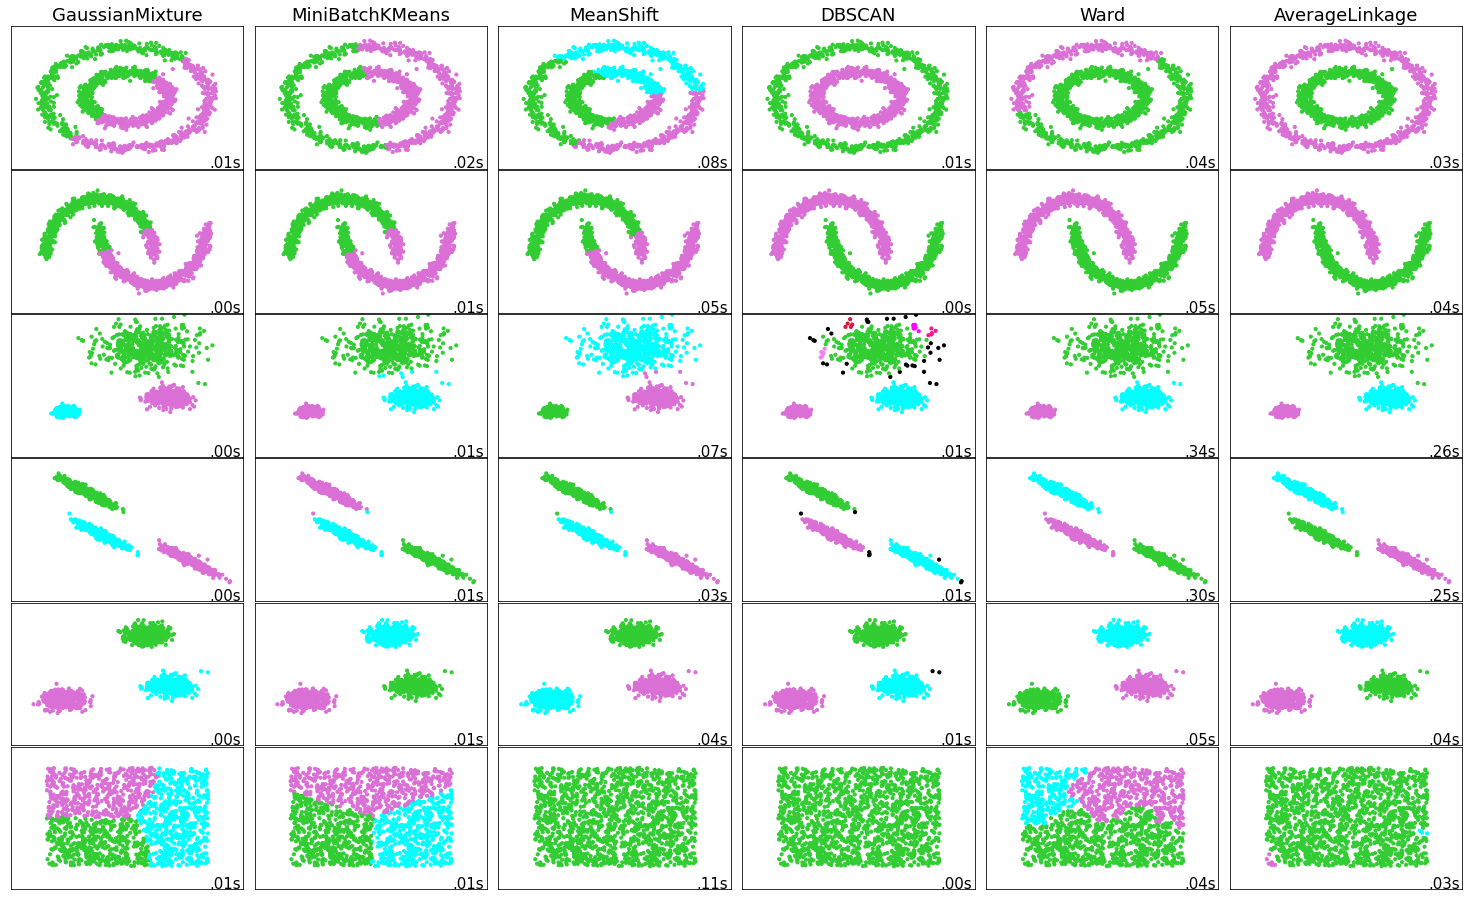

In [4]:
# ============
# Parámetros de figura
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

# ============
# Armado de figura
# ============
for i_dataset, (dataset, algorithm_params) in enumerate(datasets):
    # Actualización de parámetros de cada dataset 
    params = default_base.copy()
    params.update(algorithm_params)

    X, y = dataset

    # Normalización de datos (zscore)
    X = StandardScaler().fit_transform(X)

    # Estimación de bandwidth para Mean Shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # Conectividad para mejor algoritmos de árboles
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)

    # Conectividad simétrica
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Crear objetos cluster 
    # ============
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    dbscan = cluster.DBSCAN(eps=params['eps'])

    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'],
                                           linkage='ward',
                                           connectivity=connectivity)    

    average_linkage = cluster.AgglomerativeClustering(linkage='average',
                                                      affinity='cityblock',
                                                      n_clusters=params['n_clusters'],
                                                      connectivity=connectivity)

    clustering_algorithms = (
        ('GaussianMixture', gmm),
        ('MiniBatchKMeans', two_means),
        ('MeanShift', ms),
        ('DBSCAN', dbscan),
        ('Ward', ward),
        ('AverageLinkage', average_linkage)
    )

    # Armado de la fila de la figura. Es decir, 1 dataset con 6 métodos

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        # Aprendemos el clustering
        algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(
            cycle(
                ['limegreen', 'orchid', 'aqua', 'violet', 'magenta', 'deeppink', 'crimson', 'fuchsia', 'blue']
            ),
            int(max(y_pred) + 1)
        )))

        # Add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99,
                 .01,
                 ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes,
                 horizontalalignment='right',
                 size=15)
        plot_num += 1

plt.show()